In [1]:
import numpy as np
import cv2
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt

from bubblekicker.bubblekicker import (BubbleKicker, batchbubblekicker, bubble_properties_calculate, 
                                       _bubble_properties_filter, bubble_properties_plot)

from bubblekicker.pipelines import CannyPipeline, AdaptiveThresholdPipeline
import matplotlib
from matplotlib import pyplot as plt
import os
import seaborn as sns
import sys
%matplotlib inline

## Questo notebook vuole ottimizzare l'analisi delle immagini di granuli aerobici

usa la variabile path, in questo modo, quando lo isu te, basta che tu tolga il commento $#$ dalla tua e tu lo metta alla mia riga

come vedi sotto, facendo semplicemente la somma di queste stringhe riesci a costruire la destinazione dell'immagine

In [14]:
#path = r'C:\Users\Serena\Desktop' # PC Serena
path = r'C:\Users\Giacomo\Documents\gitRepos\Serena\shared_nbks' # PC Giacomo

path + '\\' + 'classe 5.JPG'

'C:\\Users\\Giacomo\\Documents\\gitRepos\\Serena\\shared_nbks\\classe 5.JPG'

In [6]:
img = cv2.imread(path + '\\' + 'classe 5.JPG')

In [8]:
# divide l'immagine nei layer base
img_B,img_G,img_R = cv2.split(img)

In [9]:
#crea una nuova variabile con i layer reimpostati
img2 = cv2.merge((img_R,img_G,img_B))

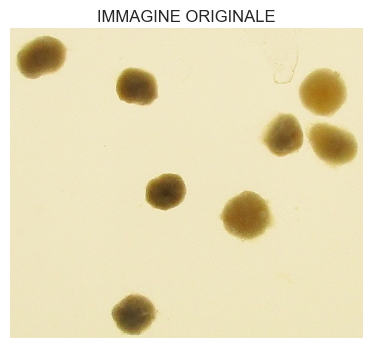

In [11]:
# salva l'immagine originale ricomposta
plt.imshow(img2), plt.xticks([]), plt.yticks([]), plt.grid('on'), plt.title('IMMAGINE ORIGINALE'); 
plt.savefig(path + '\\'+ 'OriginalRGB.jpg',dpi=500)

sotto si vede che il canale BLU da' il miglior contrasto

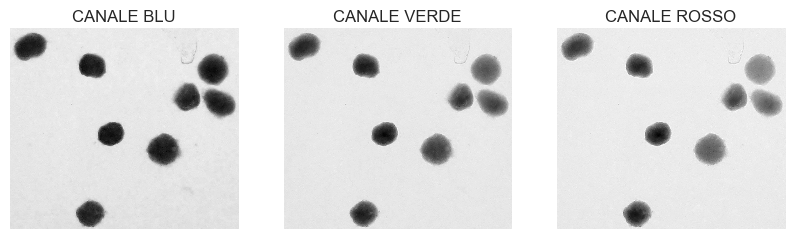

In [13]:
#mostra e salva i diversi canali
plt.figure(figsize=(10, 10))
plt.subplot(3,3,1),plt.imshow(img_B, cmap='gray'), plt.title('CANALE BLU'), plt.xticks([]), plt.yticks([]); 
plt.subplot(3,3,2), plt.imshow(img_G, cmap='gray'), plt.title('CANALE VERDE'), plt.xticks([]), plt.yticks([]); 
plt.subplot(3,3,3), plt.imshow(img_R, cmap='gray'), plt.title('CANALE ROSSO'), plt.xticks([]), plt.yticks([]); 
plt.savefig(path + '\\' + 'channels.jpg',dpi=500)

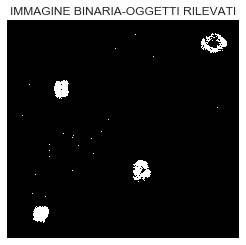

In [11]:

binImg = cv2.adaptiveThreshold(img_G, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 91,15)
plt.imshow(binImg), plt.title('IMMAGINE BINARIA-OGGETTI RILEVATI'), plt.xticks([]), plt.yticks([]),plt.grid('on');  
plt.savefig('C:\Users\Serena\Desktop\oggetti_rilevati.jpg',dpi=500)

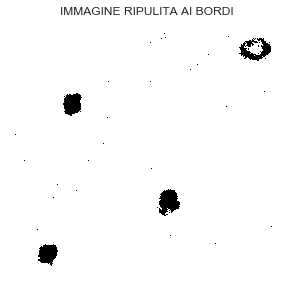

In [17]:
dst_inv = cv2.bitwise_not(binImg) 
img_clb = clear_border(dst_inv, buffer_size=5, bgval=1)
plt.figure(figsize=(5,5))
plt.imshow(img_clb), plt.title('IMMAGINE RIPULITA AI BORDI'), plt.grid('on'), plt.xticks([]), plt.yticks([]);
plt.savefig('C:\Users\Serena\Desktop\IMMAGINE RIPULITA AI BORDI.jpg', dpi=500)

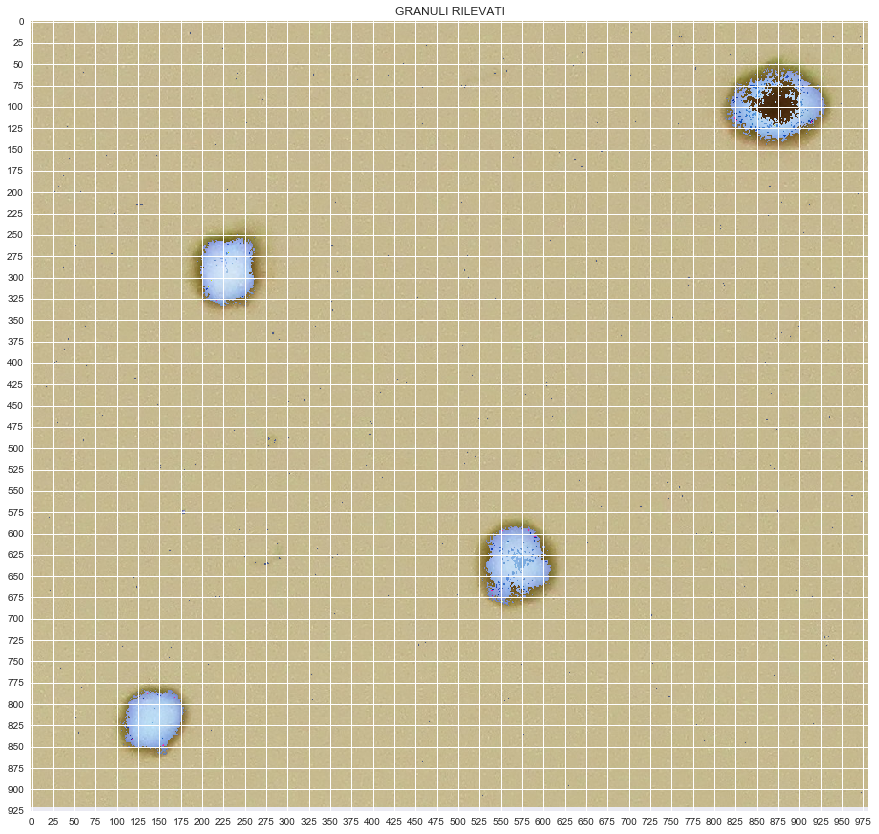

In [72]:
img_outl = cv2.merge((img_R * img_clb, img_G * img_clb, img_B * img_clb))
plt.figure(figsize=(15, 15));
plt.imshow(img_G * img_clb), plt.title('GRANULI RILEVATI')
plt.imshow(img_outl), plt.title('GRANULI RILEVATI'),plt.xticks([25*k for k in range(0,40)]),plt.yticks([25*k for k in range(0,38)])
plt.savefig('C:\Users\Serena\Desktop\GRANULI_RILEVATI.jpg',dpi=500)


In [21]:
marker_image, props = bubble_properties_calculate(img_clb,rules={'convexity': {'min':1.9 }, 'circularity_reciprocal': {'max': 5, 'min': 0.2}});



{'max': 5, 'min': 0.2}
{'min': 1.9}


In [98]:
props.head()

,area,centroid,convex_area,equivalent_diameter,perimeter,convexity,circularity_reciprocal,equivalent_diameter_mm,classe
label,,,,,,,,,
150,3952,"(291.942813765, 229.537449393)",4430,70.935483,397.983802,9.930052,3.189363,1.447663,5
398,3722,"(818.276732939, 143.197474476)",4327,68.840378,377.883297,9.849602,3.053017,1.404906,5


In [29]:
props['equivalent_diameter_mm']=props['equivalent_diameter']/49

props.head()

,area,centroid,convex_area,equivalent_diameter,perimeter,convexity,circularity_reciprocal,equivalent_diameter_mm
label,,,,,,,,
150,3952,"(291.942813765, 229.537449393)",4430,70.935483,397.983802,9.930052,3.189363,1.447663
398,3722,"(818.276732939, 143.197474476)",4327,68.840378,377.883297,9.849602,3.053017,1.404906


In [30]:
def classe(equivalent_diameter_mm):
    if equivalent_diameter_mm>= 1:
        return 5 
    elif 0.8<=equivalent_diameter_mm<1:
        return 4
    elif 0.5<=equivalent_diameter_mm<0.8:
        return 3
    elif 0.2<=equivalent_diameter_mm<0.5:
        return 2
    elif equivalent_diameter_mm<0.2:
        return 1
    

In [31]:
props["equivalent_diameter_mm"].apply(classe);


In [32]:
props['classe']=props["equivalent_diameter_mm"].apply(classe)
props.head()

,area,centroid,convex_area,equivalent_diameter,perimeter,convexity,circularity_reciprocal,equivalent_diameter_mm,classe
label,,,,,,,,,
150,3952,"(291.942813765, 229.537449393)",4430,70.935483,397.983802,9.930052,3.189363,1.447663,5
398,3722,"(818.276732939, 143.197474476)",4327,68.840378,377.883297,9.849602,3.053017,1.404906,5


In [33]:
classi=props["equivalent_diameter_mm"].apply(classe)


In [34]:
[1 for i in classi if i==1]
print('classe 1')
len( [1 for i in classi if i==1])

classe 1


0

In [35]:
[2 for i in classi if i==2] 
print('classe 2')
len([2 for i in classi if i==2]  )

classe 2


0

In [36]:
[3 for i in classi if i==3] 
print('classe 3')
len([3 for i in classi if i==3] )

classe 3


0

In [37]:
[4 for i in classi if i==4]
print('classe 4')
len([4 for i in classi if i==4])

classe 4


0

In [38]:
[5 for i in classi if i==5]
print('classe 5')
len([5 for i in classi if i==5])


classe 5


2

In [313]:
len(classi)

2

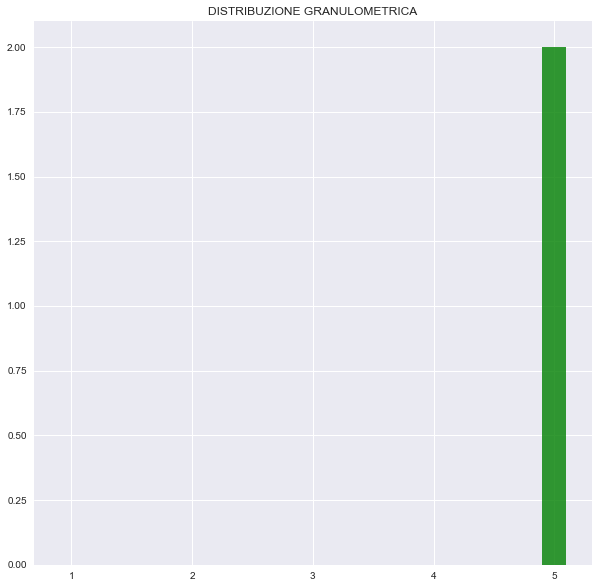

In [75]:
fig = plt.figure(figsize=(10,10));
plt.xticks([k for k in range(0,7)]);
classi.hist(bins=np.arange(1,7)-0.5, rwidth=0.2, color='green', align='mid' , alpha=0.8); #rwidth =spessore barra #non riesco a mettere il numero al centro della barra
plt.grid('on'),plt.title('DISTRIBUZIONE GRANULOMETRICA')
plt.savefig('C:\Users\Serena\Desktop\distribuzione_granulometrica.jpg',dpi=500)

In [76]:
#fig = plt.figure(figsize=(10,10))
#sns.pairplot(props)#prendi solo l'immagine che ti interessa...l'ultima
#ax = plt.subplot(111) # crei un'area di plotting
#ax.set_xticks(range(10)) # l'asse x va da 0 a 10
#ax.set_yticks(range(10)) #l'asse y va da 0 a 10
#rect=[49.7609561753, 1916.57768924]
#plt.plot([1,2,3]);
#plt.axis([-1.1, 1.1, -1.1, 1.1]) ;
# plt.xticks([0.25*k for k in range(-4,5)]) ;
#plt.yticks([-0.9, -0.4, 0.0, 0.3, 0.6, 0.85],['A','B','C','D','E','F']
#plt.plot([1,2,3]);
#plt.axis([-1.1, 1.1, -1.1, 1.1]) ;
# plt.xticks([0.25*k for k in range(-4,5)]) ;
#plt.yticks([-0.9, -0.4, 0.0, 0.3, 0.6, 0.85],['A','B','C','D','E','F']);
#plt.title('The cubic function in [-1,1]')
#plt.xlabel('my x-axis label')
#plt.ylabel('my y-axis label')
#plt.grid()

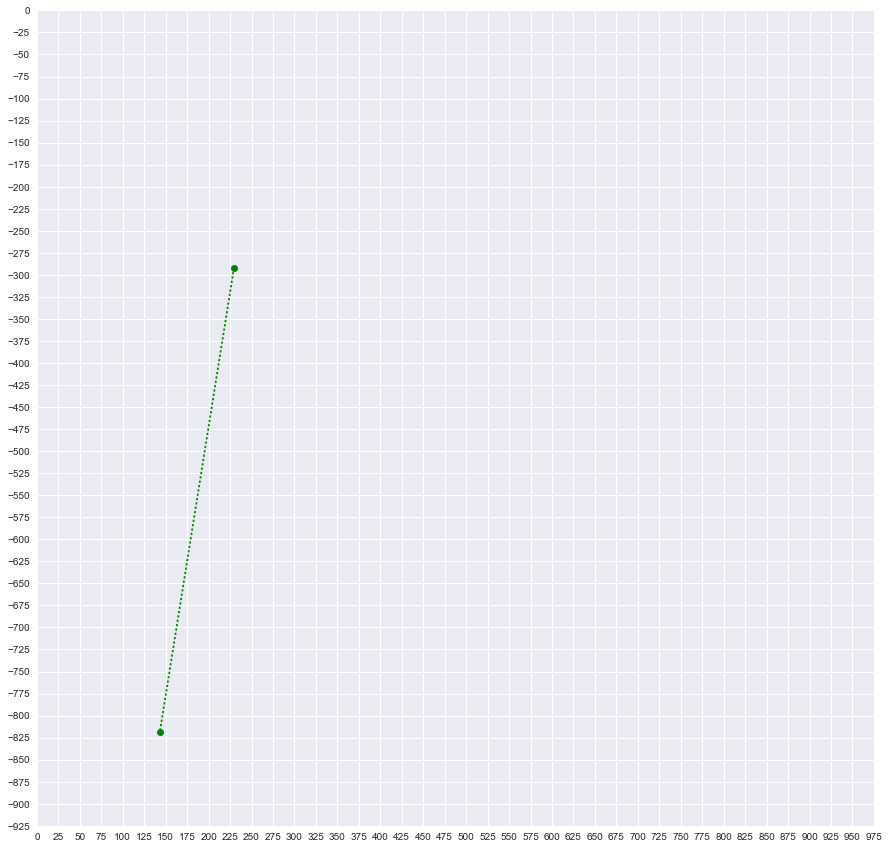

In [107]:
y=-291.942813765,-818.276732939
x=229.537449393,143.197474476
plt.figure(figsize=(15,15)) 
plt.plot(x,y,'g:o'),plt.yticks([25*k for k in range(-37,1)]),plt.xticks([25*k for k in range(0,40)]);#devi trovare il modo di sovrapporle